# Dev Preprocessing

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

########################################################
# python
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
  
########################################################
# plotting
from plotting_preprocessing import *
%matplotlib inline

########################################################
# set global rnd_seed for reproducibility
rnd_seed = 42
np.random.seed(rnd_seed)

***
# Setup Variables and Functions

In [2]:
# input vars for this sample
input_path = '../data/PhysioNetChallenge2020_Training_CPSC/Training_WFDB'

sampling_freq = 500 # Hz

channel_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
n_channels = len(channel_names)

# output vars
im_res=800
out_path = f'./output_dev/im_res_{im_res}'
slice_time_range = 5 # seconds
n_slices_max = 5 # max number of slice_time_range length slices to take from one original waveform

n_samples_per_slice = int(np.ceil(sampling_freq*slice_time_range))

Dx_classes = {
'Normal': 'Normal sinus rhythm',
'AF': 'Atrial fibrillation',
'I-AVB': 'Airst-degree atrioventricular block',
'LBBB': 'Left bundle branch block',
'PAC': 'Premature atrial complex',
'PVC': 'Premature ventricular complex',
'RBBB': 'Right bundle branch block',
'STD': 'ST-segment depression',
'STE': 'ST-segment elevation',
}

In [3]:
def load_data(in_path, fname, channel_names):
	# channels = len(channel_names)

    path_fname = f'{in_path}/{fname}'

    x = loadmat(f'{path_fname}.mat')['val']

    with open(f'{path_fname}.hea', 'r') as f:
        header_data_raw = f.readlines()

    # clean any whitespace to single spaces
    header_data = [' '.join(l.split()) for l in header_data_raw]

    # get gain and offset per channel
    gain_channel = np.zeros(n_channels)
    offset_channel = np.zeros(n_channels)
    for i in range(n_channels):
        h_line_tmp = header_data[i+1].split(' ')
        gain_channel[i] = float(h_line_tmp[2].split('/')[0]) # really an int, but cast to float for safer division later
        offset_channel[i] = int(h_line_tmp[4])

    # get Dx
    Dx = header_data[15].replace('#Dx: ', '')

    # get channel y values
    ch_values = {}
    for ich,ch in enumerate(channel_names):
        ch_values[ch] = (x[ich]-offset_channel[ich])/gain_channel[ich]

    dfp_channels = pd.DataFrame(ch_values)

    return dfp_channels, Dx

***
# Load the data

In [4]:
fnames = [f.replace('.mat', '') for f in os.listdir(input_path) if os.path.isfile(os.path.join(input_path, f)) and not f.startswith('.') and f.endswith('mat')]


In [5]:
fname = fnames[0]
# fname = 'A0011'

print(fname)

A0001


In [6]:
dfp_channels, Dx = load_data(input_path, fname, channel_names)

In [7]:
Dx

'RBBB'

In [8]:
dfp_channels

,I,II,III,aVR,aVL,aVF,V1,V2,V3,V4,V5,V6
0,0.028,0.007,-0.021,-0.017,0.024,-0.007,-0.290,-0.204,-0.096,-0.112,-0.596,-0.016
1,0.039,0.011,-0.028,-0.024,0.033,-0.009,-0.304,-0.212,-0.100,-0.110,-0.590,-0.007
2,0.045,0.015,-0.030,-0.029,0.038,-0.007,-0.317,-0.219,-0.105,-0.108,-0.582,0.002
3,0.049,0.017,-0.032,-0.032,0.041,-0.007,-0.329,-0.226,-0.109,-0.105,-0.573,0.013
4,0.054,0.020,-0.034,-0.036,0.044,-0.007,-0.342,-0.233,-0.111,-0.100,-0.561,0.024
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.254,0.245,-0.009,-0.249,0.131,0.117,-0.592,-0.445,-0.102,0.191,0.307,0.211
7496,0.256,0.246,-0.010,-0.251,0.132,0.117,-0.600,-0.447,-0.102,0.192,0.307,0.213
7497,0.258,0.248,-0.010,-0.252,0.134,0.118,-0.605,-0.449,-0.102,0.194,0.307,0.213
7498,0.259,0.249,-0.010,-0.254,0.134,0.118,-0.610,-0.450,-0.101,0.194,0.307,0.214


***
# Plotting

C:\Users\Matth\mount_sinai_health_hackathon_ekg_img\preprocessing\plotting_preprocessing.py:182: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


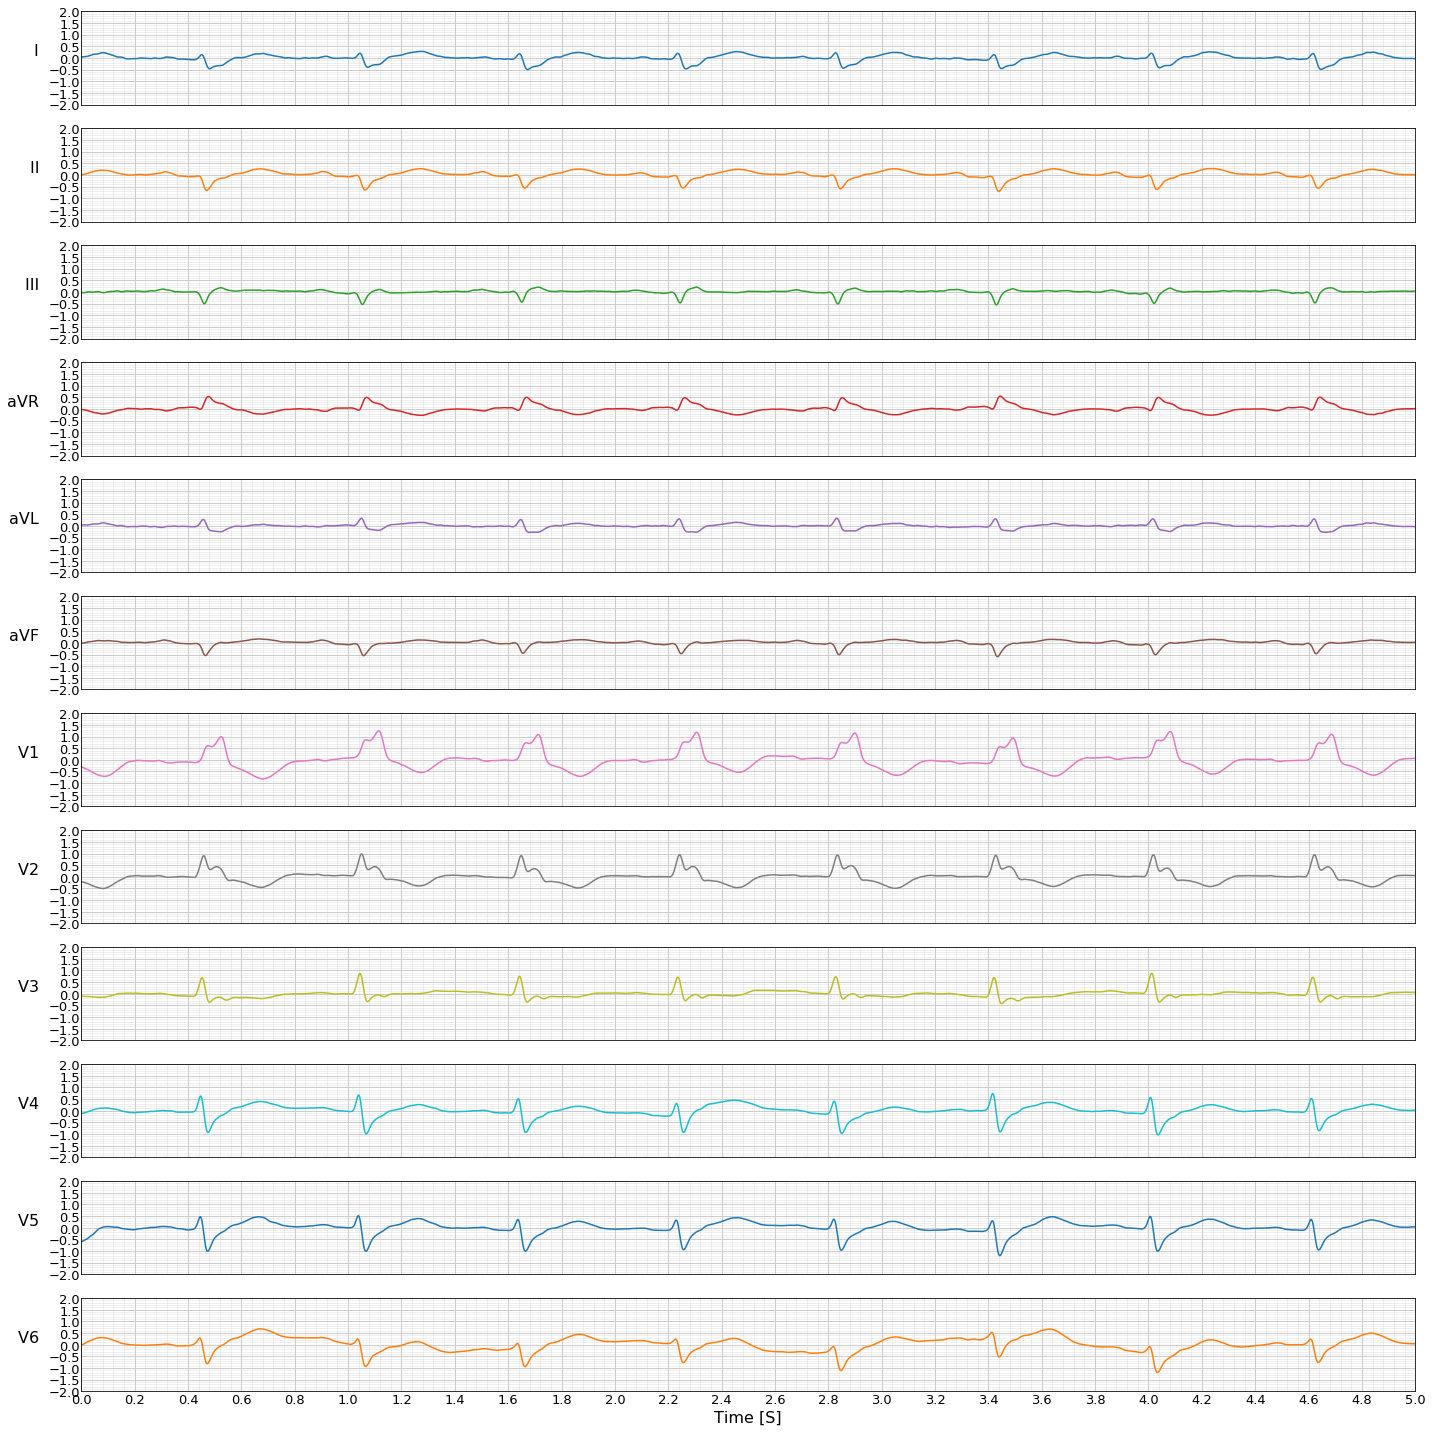

In [9]:
i_slice_start = 0
i_slice_stop = i_slice_start+n_samples_per_slice

plot_waveform(dfp_channels.iloc[i_slice_start:i_slice_stop],
    channel_names, sampling_freq,
    m_path=None,
    fname=None,
    tag='', inline=True,
    target_time_range=slice_time_range, target_im_res=im_res,
    run_parallel=False, # Turn off some error checking to speed things up
    fixed_yaxis_range=True, # Use fixed y-axes range
    show_y_minor_grid=False, # show y minor grid, turn off when running for low resolutions as it doesn't show up anyway
)

***
# Slicing

In [10]:
n_samples = len(dfp_channels.index)
# decide n_slices to take, and where to start them
n_slices = min(int(n_samples / n_samples_per_slice), n_slices_max)
starts = (1. - (1. / float(n_slices)) )*np.random.random(n_slices)

In [11]:
m_path = f'{out_path}/{Dx}'
os.makedirs(m_path, exist_ok=True)

# print each slice
for islice in range(n_slices):
    i_slice_start = int(np.ceil(starts[islice]*n_samples))
    i_slice_stop = i_slice_start+n_samples_per_slice

    plot_waveform(dfp_channels.iloc[i_slice_start:i_slice_stop],
        channel_names, sampling_freq,
        m_path=m_path,
        fname=f'{fname}-s{islice:02d}',
        tag='', inline=False,
        target_time_range=slice_time_range, target_im_res=im_res,
        run_parallel=True, # Turn off some error checking to speed things up
        fixed_yaxis_range=True, # Use fixed y-axes range
        show_y_minor_grid=False, # show y minor grid, turn off when running for low resolutions as it doesn't show up anyway
    )